# Time Series Analysis of Team Statistics


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import yaml
from IPython.display import Markdown, display

In [3]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [4]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [14]:
# load team data
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics.csv"))
team_statistics_df.info()
team_statistics_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91649 entries, 0 to 91648
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   91649 non-null  int64  
 1   gameDate                 91649 non-null  object 
 2   teamCity                 91649 non-null  object 
 3   teamName                 91649 non-null  object 
 4   teamId                   91649 non-null  int64  
 5   opponentTeamCity         91649 non-null  object 
 6   opponentTeamName         91649 non-null  object 
 7   opponentTeamId           91649 non-null  int64  
 8   home                     91649 non-null  int64  
 9   win                      91649 non-null  int64  
 10  teamScore                91649 non-null  int64  
 11  opponentScore            91649 non-null  int64  
 12  assists                  91645 non-null  float64
 13  blocks                   91632 non-null  float64
 14  steals                

gameId             gameDate   teamCity teamName      teamId  \
0  22401058  2025-03-26 22:00:00     Boston  Celtics  1610612738   
1  22401058  2025-03-26 22:00:00    Phoenix     Suns  1610612756   
2  22401057  2025-03-26 21:00:00     Denver  Nuggets  1610612743   
3  22401057  2025-03-26 21:00:00  Milwaukee    Bucks  1610612749   
4  22401054  2025-03-26 19:30:00   Brooklyn     Nets  1610612751   

  opponentTeamCity opponentTeamName  opponentTeamId  home  win  ...  \
0          Phoenix             Suns      1610612756     0    1  ...   
1           Boston          Celtics      1610612738     1    0  ...   
2        Milwaukee            Bucks      1610612749     1    1  ...   
3           Denver          Nuggets      1610612743     0    0  ...   
4          Toronto          Raptors      1610612761     1    0  ...   

   biggestScoringRun  leadChanges  pointsFastBreak  pointsFromTurnovers  \
0               15.0          0.0              9.0                 16.0   
1               10.0          0.0              9.0                  7.0   
2                9.0          2.0             20.0                 18.0   
3                7.0          2.0              5.0                 17.0   
4                8.0          0.0             12.0                  7.0   

   pointsInThePaint  pointsSecondChance  timesTied  timeoutsRemaining  \
0              44.0                17.0        0.0                1.0   
1              36.0                16.0        0.0                1.0   
2              64.0                16.0        4.0                1.0   
3              56.0                13.0        4.0                0.0   
4              46.0                12.0        1.0                1.0   

   seasonWins  seasonLosses  
0        54.0          19.0  
1        35.0          38.0  
2        46.0          28.0  
3        40.0          32.0  
4        23.0          50.0  

[5 rows x 47 columns]

In [15]:
# time series where gameDate is the time column
team_statistics_df["gameDate"] = pd.to_datetime(team_statistics_df["gameDate"])

In [17]:
# drop columns not needed
cols_to_drop = ["gameId", "teamCity", "teamName", "opponentTeamCity", "opponentTeamName",
                "fieldGoalsAttempted", "fieldGoalsMade",
                "threePointersAttempted", "threePointersMade",
                "freeThrowsAttempted", "freeThrowsMade",
                "reboundsDefensive", "reboundsOffensive"
                ]
team_df = team_statistics_df
team_df.drop(columns=cols_to_drop, inplace=True)

In [20]:
team_df.head()

gameDate      teamId  opponentTeamId  home  win  teamScore  \
0 2025-03-26 22:00:00  1610612738      1610612756     0    1        132   
1 2025-03-26 22:00:00  1610612756      1610612738     1    0        102   
2 2025-03-26 21:00:00  1610612743      1610612749     1    1        127   
3 2025-03-26 21:00:00  1610612749      1610612743     0    0        117   
4 2025-03-26 19:30:00  1610612751      1610612761     1    0         86   

   opponentScore  assists  blocks  steals  ...  biggestScoringRun  \
0            102     33.0     7.0     8.0  ...               15.0   
1            132     22.0     3.0     7.0  ...               10.0   
2            117     36.0     4.0     6.0  ...                9.0   
3            127     30.0     6.0     4.0  ...                7.0   
4            116     16.0     9.0     6.0  ...                8.0   

   leadChanges  pointsFastBreak  pointsFromTurnovers  pointsInThePaint  \
0          0.0              9.0                 16.0              44.0   
1          0.0              9.0                  7.0              36.0   
2          2.0             20.0                 18.0              64.0   
3          2.0              5.0                 17.0              56.0   
4          0.0             12.0                  7.0              46.0   

   pointsSecondChance  timesTied  timeoutsRemaining  seasonWins  seasonLosses  
0                17.0        0.0                1.0        54.0          19.0  
1                16.0        0.0                1.0        35.0          38.0  
2                16.0        4.0                1.0        46.0          28.0  
3                13.0        4.0                0.0        40.0          32.0  
4                12.0        1.0                1.0        23.0          50.0  

[5 rows x 34 columns]

In [19]:
team_df.describe()

gameDate        teamId  opponentTeamId  \
count                          91649  9.164900e+04    9.164900e+04   
mean   2006-01-14 20:38:55.725649024  1.610613e+09    1.610613e+09   
min              1981-11-03 20:00:00  1.610613e+09    1.610613e+09   
25%              1996-03-17 20:00:00  1.610613e+09    1.610613e+09   
50%              2006-03-10 19:00:00  1.610613e+09    1.610613e+09   
75%              2015-12-07 19:30:00  1.610613e+09    1.610613e+09   
max              2025-03-26 22:00:00  1.610613e+09    1.610613e+09   
std                              NaN  8.560837e+00    8.562666e+00   

               home           win     teamScore  opponentScore       assists  \
count  91649.000000  91649.000000  91649.000000   91649.000000  91645.000000   
mean       0.499471      0.498347    102.799725     102.828869     23.115991   
min        0.000000      0.000000     49.000000      49.000000      4.000000   
25%        0.000000      0.000000     93.000000      93.000000     19.000000   
50%        0.000000      0.000000    102.000000     102.000000     23.000000   
75%        1.000000      1.000000    112.000000     112.000000     27.000000   
max        1.000000      1.000000    176.000000     176.000000     52.000000   
std        0.500002      0.500000     13.700946      13.710616      5.524858   

             blocks        steals  ...  biggestScoringRun  leadChanges  \
count  91632.000000  91341.000000  ...        2150.000000  2150.000000   
mean       5.003121      7.905628  ...          10.153488     6.716279   
min        0.000000      0.000000  ...           5.000000     0.000000   
25%        3.000000      6.000000  ...           8.000000     2.000000   
50%        5.000000      8.000000  ...          10.000000     5.000000   
75%        7.000000     10.000000  ...          12.000000    10.000000   
max       23.000000     27.000000  ...          24.000000    42.000000   
std        2.654206      3.046092  ...           2.674992     6.056848   

       pointsFastBreak  pointsFromTurnovers  pointsInThePaint  \
count      2150.000000          2150.000000       2150.000000   
mean         15.486512            17.525116         48.939535   
min           0.000000             0.000000         18.000000   
25%          11.000000            13.000000         42.000000   
50%          15.000000            17.000000         48.000000   
75%          20.000000            22.000000         56.000000   
max          46.000000            45.000000         88.000000   
std           6.614039             6.710324         10.397187   

       pointsSecondChance    timesTied  timeoutsRemaining   seasonWins  \
count         2150.000000  2150.000000        2150.000000  2150.000000   
mean            14.128372     4.840930           0.452093    18.233023   
min              0.000000     0.000000           0.000000     0.000000   
25%             10.000000     2.000000           0.000000     8.000000   
50%             14.000000     4.000000           0.000000    16.000000   
75%             18.000000     7.000000           1.000000    27.000000   
max             36.000000    22.000000           1.000000    60.000000   
std              5.706591     4.124381           0.497815    12.536114   

       seasonLosses  
count   2150.000000  
mean      18.280465  
min        0.000000  
25%        8.000000  
50%       17.000000  
75%       27.000000  
max       57.000000  
std       12.495395  

[8 rows x 34 columns]

## EDA

In [27]:
team_df.columns

Index(['gameDate', 'teamId', 'opponentTeamId', 'home', 'win', 'teamScore',
       'opponentScore', 'assists', 'blocks', 'steals', 'fieldGoalsPercentage',
       'threePointersPercentage', 'freeThrowsPercentage', 'reboundsTotal',
       'foulsPersonal', 'turnovers', 'plusMinusPoints', 'numMinutes',
       'q1Points', 'q2Points', 'q3Points', 'q4Points', 'benchPoints',
       'biggestLead', 'biggestScoringRun', 'leadChanges', 'pointsFastBreak',
       'pointsFromTurnovers', 'pointsInThePaint', 'pointsSecondChance',
       'timesTied', 'timeoutsRemaining', 'seasonWins', 'seasonLosses'],
      dtype='object')

In [65]:
# plot all cols, except teamId and opponentTeamId in a line plot wehre gameDate is on the x axis
# plot all of them in one big plot with subplots
def plot_all_cols(df, cols):
    dont_plot = ["teamId", "opponentTeamId"]
    df = team_df.drop(columns=dont_plot)
    fig, axs = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(12,4*len(df.columns)))
    for i, col in enumerate(df.columns):
        if col not in dont_plot:
            axs[i].plot(df["gameDate"], df[col])
            axs[i].set_title(col)
            axs[i].set_xlabel("gameDate")
            axs[i].set_ylabel(col)
            # more space between the plots
            plt.subplots_adjust(hspace=0.5)
    plt.show()

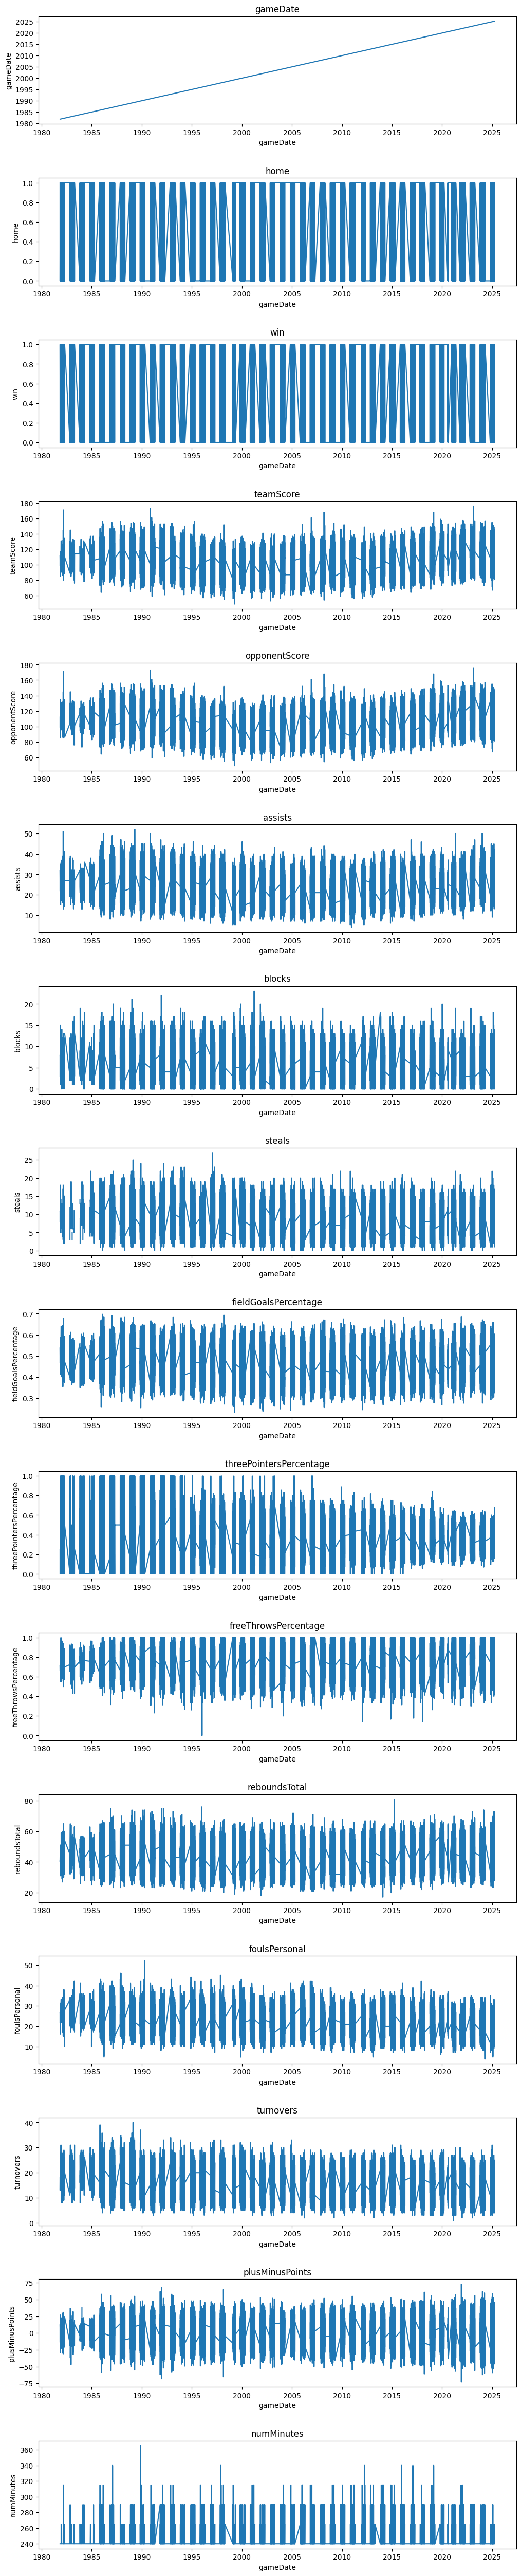

In [67]:
plot_all_cols(team_df, team_df.columns)

Okay this is now the plot for all teams, this is not very helpful.

However, we can see that some statistic was only started to be collected later. Thus, let's split agian the `df` and select only those columns which have the record since 1981

In [68]:
cols_to_keep = []
# select only cols which have a min value in the year 1981
for col in team_df.columns:
    if col == "gameDate":
        continue
    # if we would select only that col and gameDate, would the min of gameDate be 1981?
    col_df = team_df[["gameDate", col]]
    # drop all nan and 0s
    col_df = col_df.dropna()
    col_df = col_df[col_df[col] != 0]
    # get min
    min_year = col_df["gameDate"].min().year
    if min_year == 1981:
        cols_to_keep.append(col)

team_df = team_df[["gameDate"] + cols_to_keep]
team_df.describe()

gameDate        teamId  opponentTeamId  \
count                          91649  9.164900e+04    9.164900e+04   
mean   2006-01-14 20:38:55.725649024  1.610613e+09    1.610613e+09   
min              1981-11-03 20:00:00  1.610613e+09    1.610613e+09   
25%              1996-03-17 20:00:00  1.610613e+09    1.610613e+09   
50%              2006-03-10 19:00:00  1.610613e+09    1.610613e+09   
75%              2015-12-07 19:30:00  1.610613e+09    1.610613e+09   
max              2025-03-26 22:00:00  1.610613e+09    1.610613e+09   
std                              NaN  8.560837e+00    8.562666e+00   

               home           win     teamScore  opponentScore       assists  \
count  91649.000000  91649.000000  91649.000000   91649.000000  91645.000000   
mean       0.499471      0.498347    102.799725     102.828869     23.115991   
min        0.000000      0.000000     49.000000      49.000000      4.000000   
25%        0.000000      0.000000     93.000000      93.000000     19.000000   
50%        0.000000      0.000000    102.000000     102.000000     23.000000   
75%        1.000000      1.000000    112.000000     112.000000     27.000000   
max        1.000000      1.000000    176.000000     176.000000     52.000000   
std        0.500002      0.500000     13.700946      13.710616      5.524858   

             blocks        steals  fieldGoalsPercentage  \
count  91632.000000  91341.000000          91649.000000   
mean       5.003121      7.905628              0.460987   
min        0.000000      0.000000              0.234000   
25%        3.000000      6.000000              0.422000   
50%        5.000000      8.000000              0.460000   
75%        7.000000     10.000000              0.500000   
max       23.000000     27.000000              0.697000   
std        2.654206      3.046092              0.057522   

       threePointersPercentage  freeThrowsPercentage  reboundsTotal  \
count             91649.000000           91649.00000   91649.000000   
mean                  0.343249               0.75815      42.767919   
min                   0.000000               0.00000      17.000000   
25%                   0.261000               0.69600      38.000000   
50%                   0.345000               0.76500      43.000000   
75%                   0.429000               0.82600      47.000000   
max                   1.000000               1.00000      81.000000   
std                   0.147039               0.10003       6.751799   

       foulsPersonal     turnovers  plusMinusPoints    numMinutes  
count   91649.000000  91595.000000     91015.000000  91649.000000  
mean       21.562505     14.847546         0.123782    241.713057  
min         4.000000      1.000000       -73.000000    240.000000  
25%        18.000000     12.000000        -9.000000    240.000000  
50%        21.000000     15.000000         1.000000    240.000000  
75%        25.000000     17.000000         9.000000    240.000000  
max        52.000000     40.000000        73.000000    365.000000  
std         4.754360      4.148831        13.745173      7.328626

## Let's select some teams

In [82]:
def plot_time_series(dataframes, columns, fig_colsize=6):
    # Number of columns excluding 'gameDate'
    num_columns = len(columns) - 1

    fig, axes = plt.subplots(nrows=num_columns, ncols=len(dataframes), figsize=(fig_colsize*len(dataframes), num_columns * 3), sharex=True)

    # Iterate over each dataframe and each column
    for col_idx, column in enumerate(columns):
        if column == 'gameDate':
            continue

        for df_idx, df in enumerate(dataframes):
            ax = axes[col_idx-1, df_idx] if num_columns > 1 else axes[df_idx]
            ax.plot(df['gameDate'], df[column], label=f'DF {df_idx + 1}')
            ax.set_title(f'{column} (DF {df_idx + 1})')
            ax.set_xlabel('Game Date')
            ax.set_ylabel(column)
            ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [80]:
# select 3 teams randomly and plot the plots for those
teamsIds = team_df["teamId"].unique()
np.random.seed(42)
teamsIds_chosen = np.random.choice(teamsIds, 3, replace=False)

teamsIds_chosen

# create 3 data frames selected only by those teams
team_dfs_chosen = []
for teamId in teamsIds_chosen:
    team_dfs_chosen.append(team_df[team_df["teamId"] == teamId])

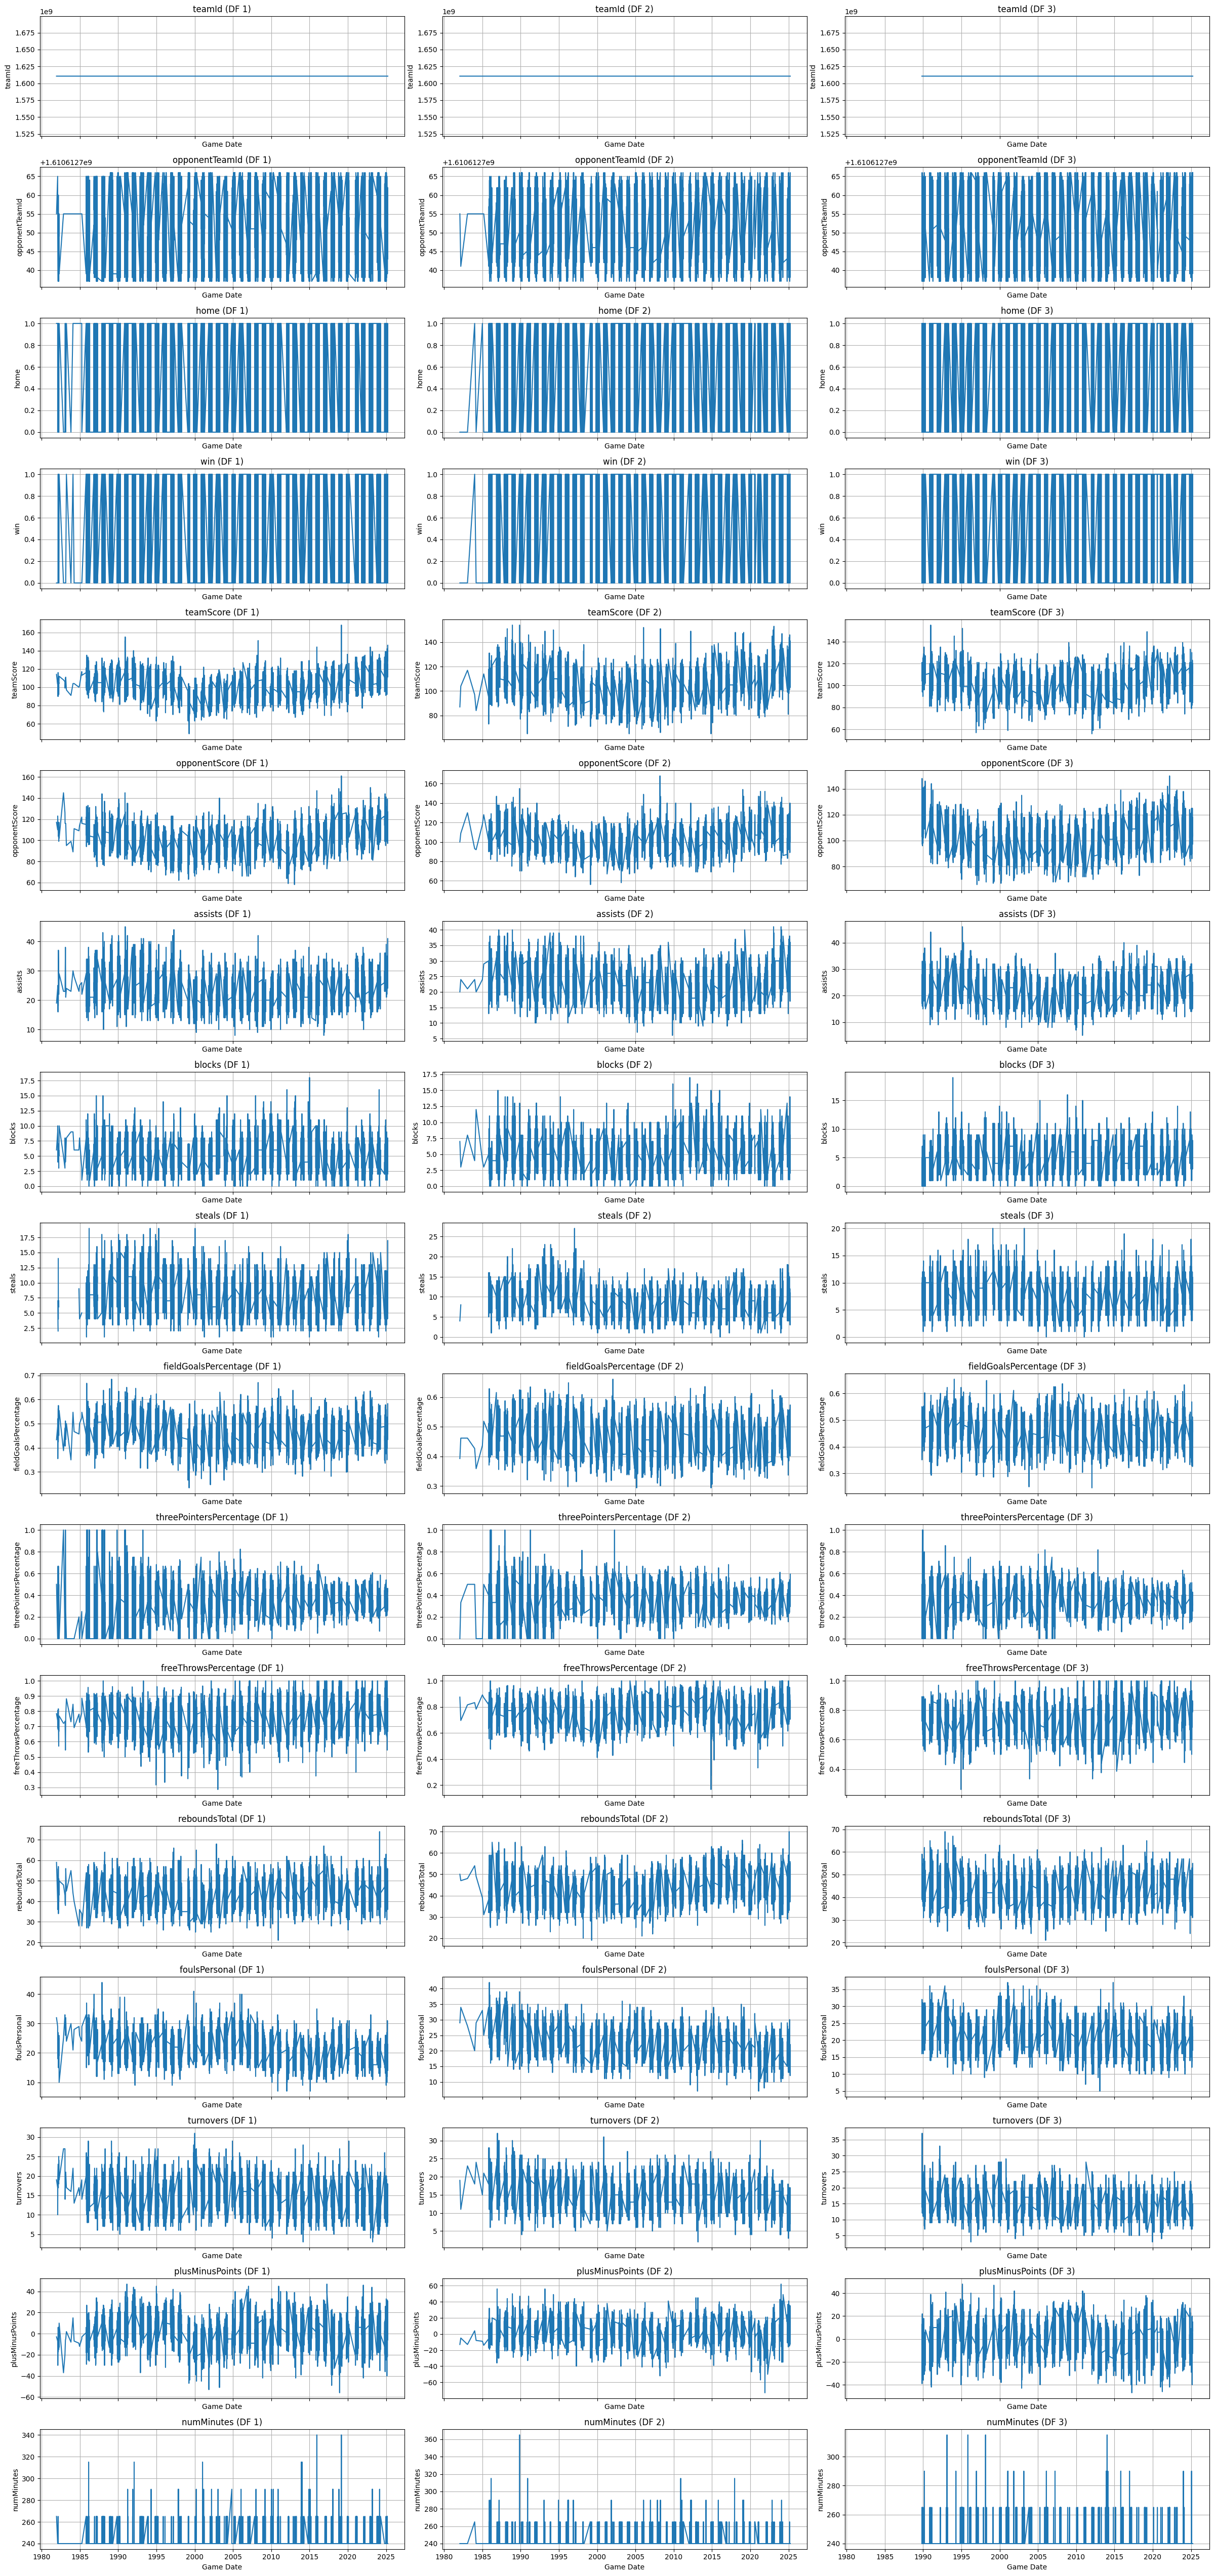

In [83]:
# plot teams
plot_time_series(team_dfs_chosen, team_dfs_chosen[0].columns, fig_colsize=8)

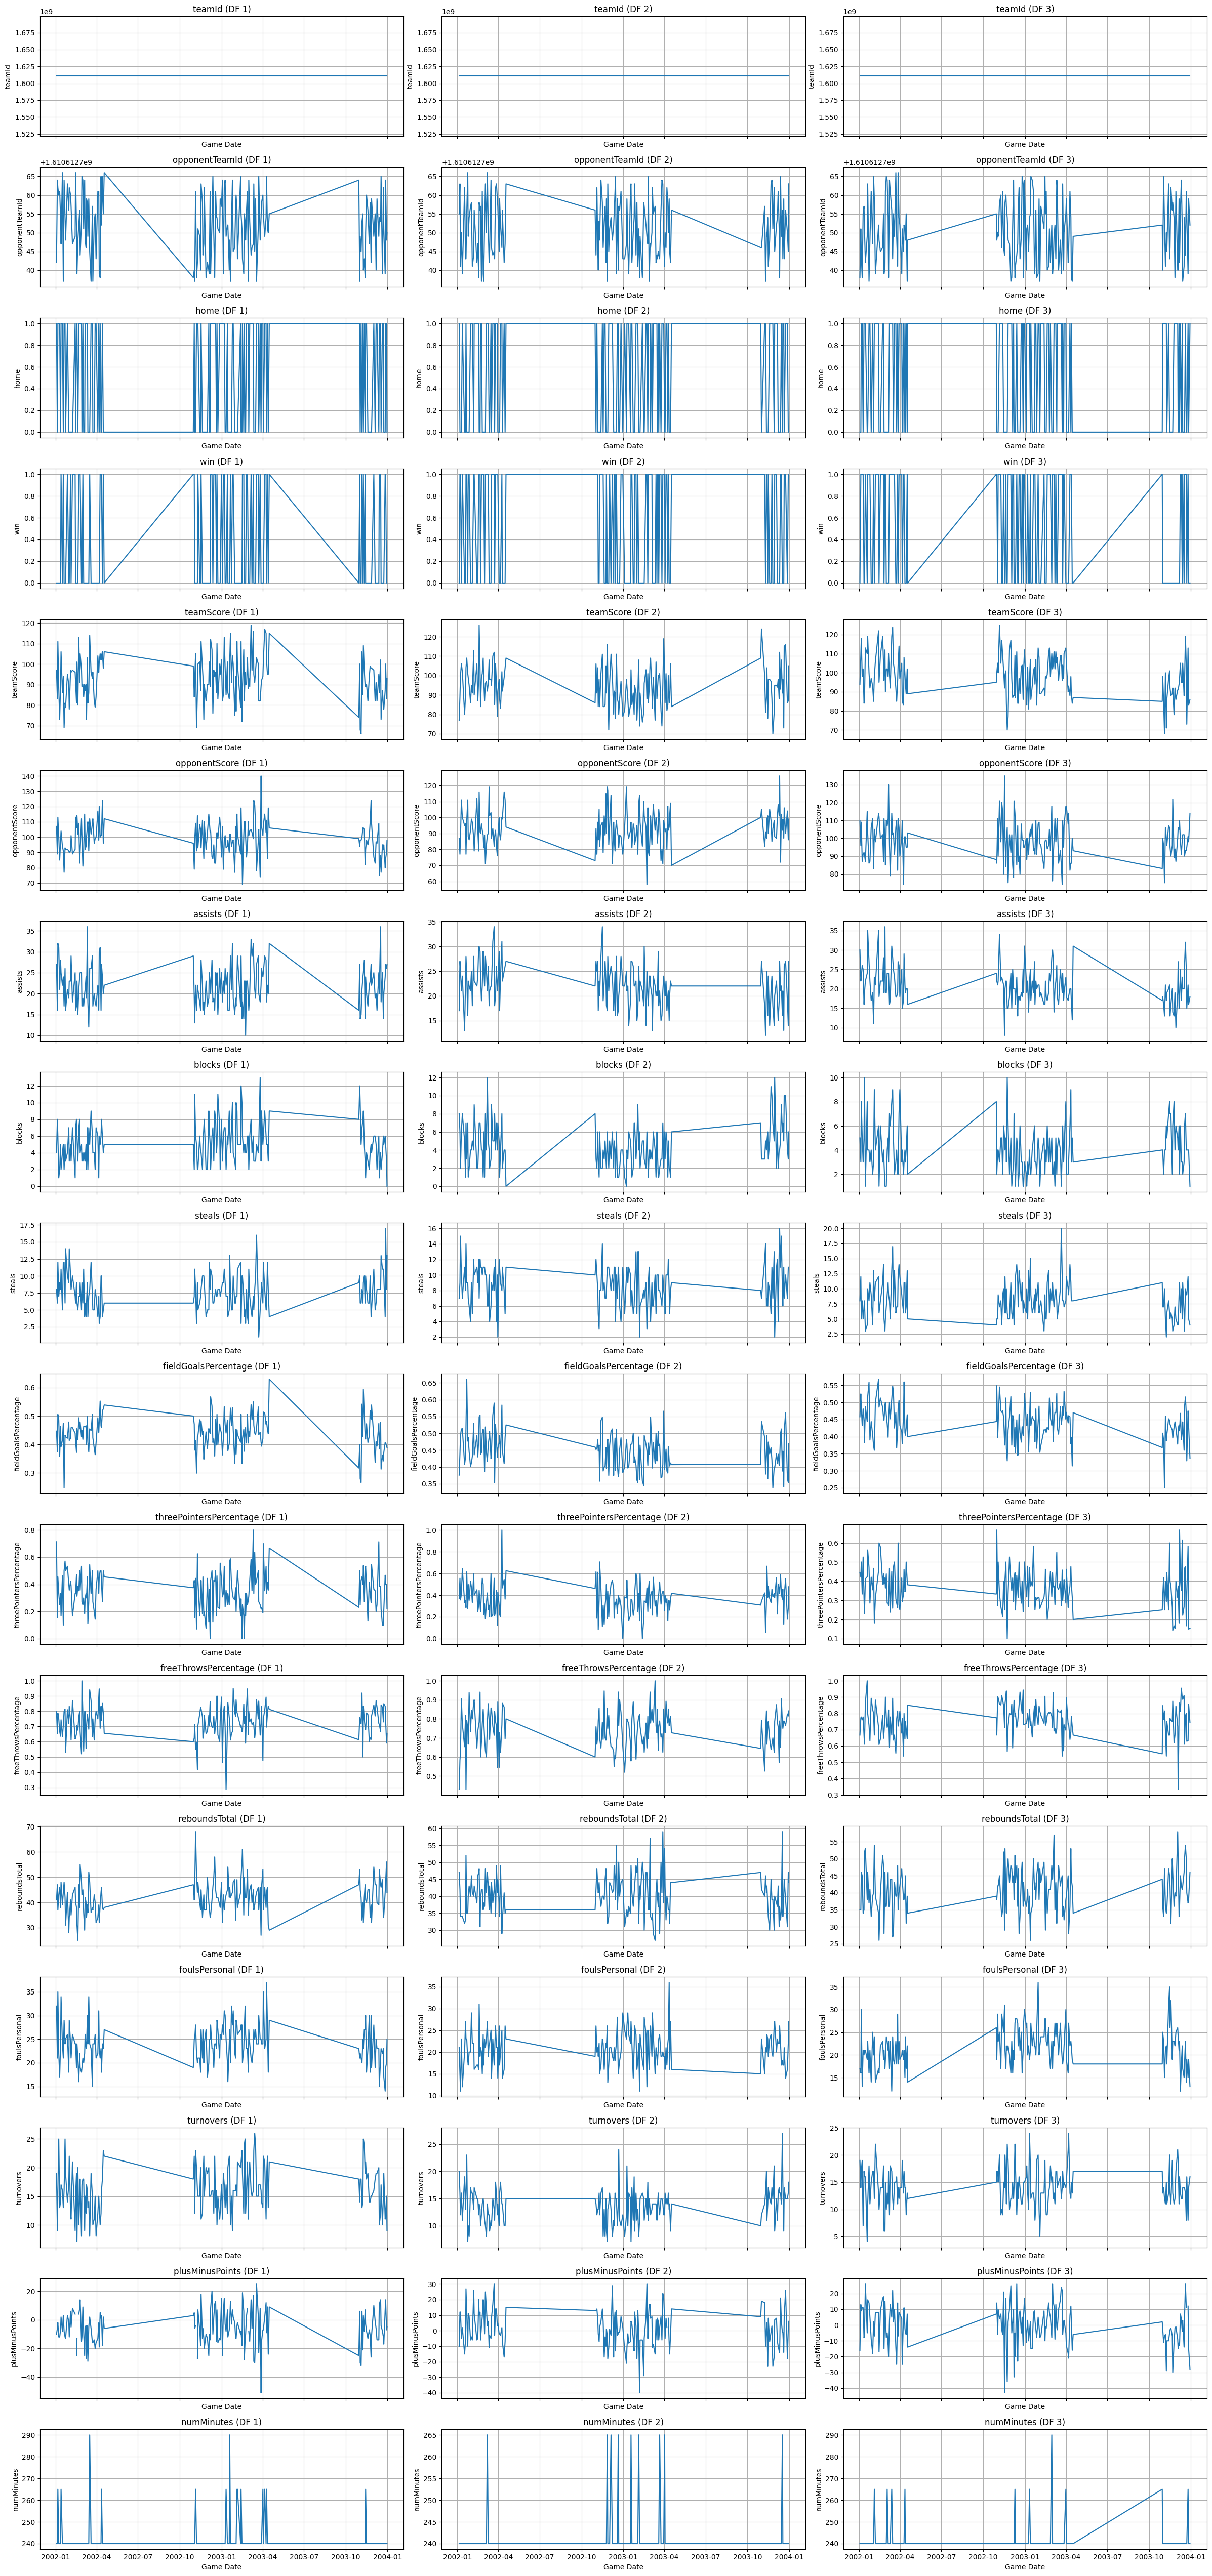

In [91]:
# hard to tell something, lets select only one year

year = 2002

team_dfs_chosen_year = []
for t in team_dfs_chosen:
    # filter for rows that are in the year 'year' or year+1
    team_dfs_chosen_year.append(t[t["gameDate"].dt.year.isin([year, year+1])])

# plot again
plot_time_series(team_dfs_chosen_year, team_dfs_chosen_year[0].columns, fig_colsize=8)

`NumMinutes` probably not good.

# TS analysis of teamScore

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [116]:
# select
ts = team_dfs_chosen[0][["gameDate", "teamScore"]]

# gameDate to echotime and make it the index
ts["gameDate"] = pd.to_datetime(ts["gameDate"])
ts.set_index("gameDate", inplace=True)
ts = ts.asfreq('M')  # 'D' for daily frequency, adjust as needed
ts.head()
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 519 entries, 1981-12-31 20:00:00 to 2025-02-28 20:00:00
Freq: ME
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   teamScore  43 non-null     float64
dtypes: float64(1)
memory usage: 8.1 KB


<ipython-input-116-dfd9e6768f9f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["gameDate"] = pd.to_datetime(ts["gameDate"])
<ipython-input-116-dfd9e6768f9f>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq('M')  # 'D' for daily frequency, adjust as needed


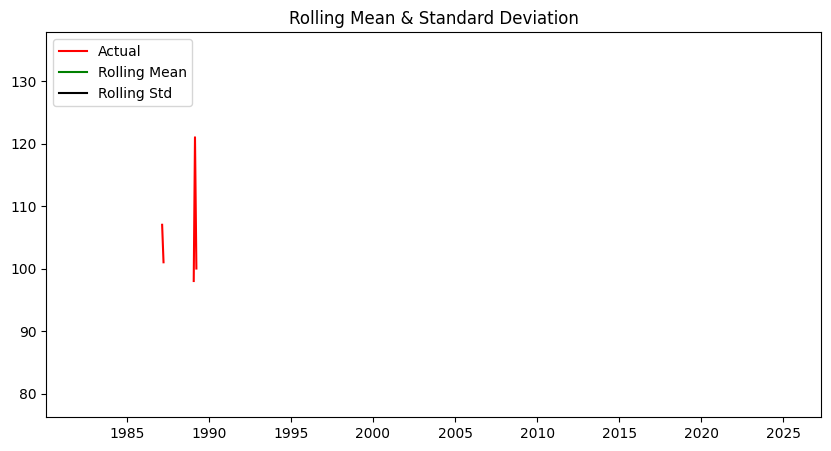

In [117]:
rolmean=ts.rolling(window=12).mean()
rolstd=ts.rolling(window=12).std()
#print(rolmean.head(22))


plt.figure(figsize=(10,5))
actual=plt.plot(ts, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean')
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False) # block=False allows the code to keep running

In [115]:
# seasonal_decompose
# ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
decomposition = seasonal_decompose(ts, model='additive')

# plot
decomposition.plot()
plt.show()

ValueError: This function does not handle missing values